In [1]:
import sys
sys.path.append("../")
from pipeline.dataset.dataset_loader import DatasetLoader
import pandas as pd
from darts.models import (
    TFTModel,
)
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk

import ray
from ray import tune
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"
ray.init(num_gpus=1)

{'node_ip_address': '130.149.248.55',
 'raylet_ip_address': '130.149.248.55',
 'redis_address': '130.149.248.55:41682',
 'object_store_address': '/tmp/ray/session_2022-03-11_16-38-25_005979_232343/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-11_16-38-25_005979_232343/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-11_16-38-25_005979_232343',
 'metrics_export_port': 41382,
 'gcs_address': '130.149.248.55:33879',
 'node_id': '32de4e274eb5f46c561a8dfa3ff346a216f51a19de98f8a3e7bb1666'}

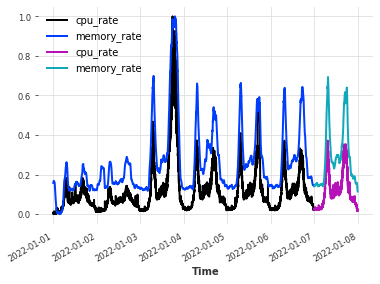

In [14]:
dl =  DatasetLoader( 'data/cpu_memory_rate.csv', "Time", ["cpu_rate","memory_rate"],
                    resample_freq="1min", augment=False, shift_df_datetime="2022-01-01 00:00:00")
train, val, _ = dl.get_train_val_test(train_size=6/7,val_test_ratio=1.0)
train.plot()
val.plot()
train.append((dl.augment_specific_times(train, [slice("2022-01-06 00:00:00", None)])))
train = dl.augment_series(train)

In [21]:
val

<TimeSeries (DataArray) (Time: 1440, component: 2, sample: 1)>
array([[[0.02319301],
        [0.14132873]],

       [[0.02297346],
        [0.14133554]],

       [[0.02380802],
        [0.1414773 ]],

       ...,

       [[0.02002927],
        [0.11723802]],

       [[0.02177123],
        [0.11573704]],

       [[0.01640017],
        [0.11432984]]])
Coordinates:
  * Time       (Time) datetime64[ns] 2022-01-07 ... 2022-01-07T23:59:00
  * component  (component) object 'cpu_rate' 'memory_rate'
Dimensions without coordinates: sample

In [17]:
    
quantiles = [0.1, 0.5, 0.9]
model = TFTModel(
    input_chunk_length=30,
    output_chunk_length=5,
    batch_size=64,
    hidden_size = 64,
    lstm_layers= 4,
    num_attention_heads= 8,
    optimizer_kwargs= {'lr': 0.001},
    n_epochs=31, 
#         full_attention = False,
    dropout= 0.05,
#         hidden_continuous_size= config["hidden_continuous_size"],
    random_state=1,
    log_tensorboard=True,
    add_encoders={
        'datetime_attribute': {'past': ['dayofweek'], 'future': ['dayofweek']},
        "position": {"past": ["relative"], "future": ["relative"]},
        'custom': {'past': [lambda idx: idx.minute + (idx.hour * 60)],
                   'future': [lambda idx: idx.minute + (idx.hour * 60)]},
        'transformer': Scaler()
    },
    likelihood=QuantileRegression(
        quantiles=quantiles
    ), 
    work_dir="logs/tft",
    torch_device_str='cuda:0'
)

model.fit(train, val_series=val, verbose=True)



[2022-03-11 20:23:29,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112286 samples.
[2022-03-11 20:23:29,637] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 112286 samples.
[2022-03-11 20:23:29,678] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-11 20:23:29,678] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/31 [00:00<?, ?it/s]

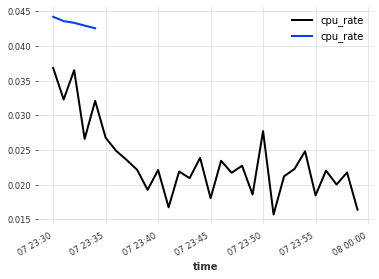

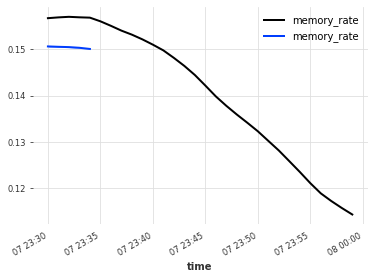

In [20]:
pred_len = 30
pred = model.predict(series=val[:-pred_len], n=5, num_samples=500)
for i in range(pred.n_components):
    val[-pred_len:].univariate_component(i).plot()
    pred.univariate_component(i).plot(low_quantile=0.1, high_quantile=0.9)
    plt.show()

In [ ]:
pred = model.predict(n=30, num_samples=500)
rr = 0.0
for rho in quantiles:
    rr += rho_risk(val[:30], pred, rho=rho)
rr = rr / len(quantiles)

tune.report(mean_loss=rr)